In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as ss

In [2]:
# Lattice parameter
a = 10.0

alpha_over_a = 0.01
alpha = alpha_over_a * a
alpha2 = alpha * alpha
alpha3 = alpha * alpha2
area_per_particle = 0.5 * np.sqrt(3.0) * (a * a)

# Radius of vesicle
R = np.array ([10.0, 15.0, 30.0]) * alpha
R2 = R * R
R3 = R2 * R

# Velocity profile is V * exp (-beta * theta2)
v_m = 1.0
V = area_per_particle * v_m / (4.0 * np.pi * alpha2)

V = 1.0 / (4.0 * np.pi) #in units of W_m/alpha^2

S = 1.0 / (4.0 * np.pi) #in units of F_m/alpha^2
              
N_div = 100000
N_Legendre = 87

In [3]:
th = np.linspace (0.0, np.pi, N_div)

th2 = th * th

cos_th = np.cos (th)
sin_th = np.sin (th)

v0_r = []
sig0_r = []

for _R2 in R2:

    beta = _R2 / (4.0 * alpha2)

    v0_r.append (V * np.exp (-beta * th2))
    
    sig0_r.append (-S * np.exp (-beta * th2))

In [4]:
leg = []
leg_poly = []

for i in range (N_Legendre):

    leg_poly.append (ss.legendre (i))

    leg.append (leg_poly[i] (cos_th))


In [5]:
C_v_list = []
C_sig_list = []

for j in range (R.shape[0]):

    C_v = np.zeros (N_Legendre)
    C_sig = np.zeros (N_Legendre)

    for i in range (N_Legendre):
    
        C_v[i] = (2.0 * float(i) + 1.0) / 2.0 * np.trapz (v0_r[j] * leg[i] * sin_th, th)
        C_sig[i] = (2.0 * float(i) + 1.0) / 2.0 * np.trapz (sig0_r[j] * leg[i] * sin_th, th)
    
    C_v_list.append (C_v)
    C_sig_list.append (C_sig)    

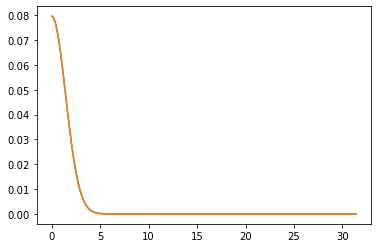

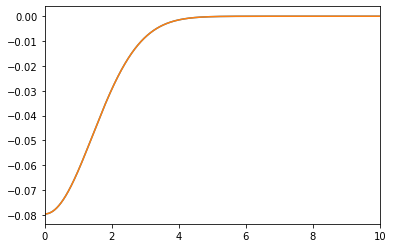

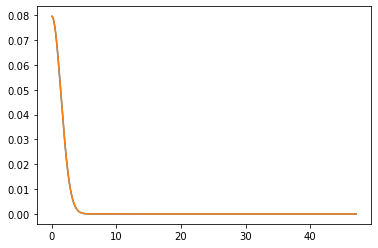

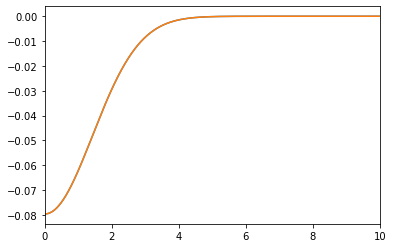

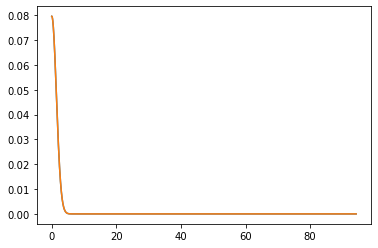

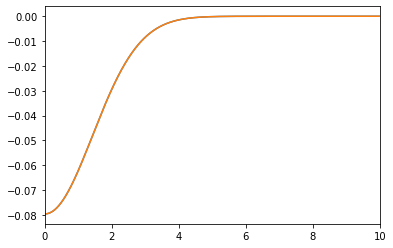

In [6]:
for j in range (R.shape[0]):

    v0_r_rec = np.zeros_like (v0_r[j])
    sig0_r_rec = np.zeros_like (sig0_r[j])

    for i in range (N_Legendre):
        v0_r_rec += C_v_list[j][i] * leg[i]
        sig0_r_rec += C_sig_list[j][i] * leg[i]

    plt.figure ()
    plt.plot (R[j] * th / alpha, v0_r[j])
    plt.plot (R[j] * th / alpha, v0_r_rec)

    plt.figure ()
    plt.plot (R[j] * th / alpha, sig0_r[j])
    plt.plot (R[j] * th / alpha, sig0_r_rec)
    plt.xlim ([0.0, 10.0])

In [7]:
k_acc = np.load ("k_acc.npy")

fc1_v_list = []
fc2_v_list = []

fc1_sig_list = []
fc2_sig_list = []

for j in range (R.shape[0]):
    
    fc1_v = np.zeros (N_Legendre)
    fc2_v = np.zeros (N_Legendre)

    fc1_sig = np.zeros (N_Legendre)
    fc2_sig = np.zeros (N_Legendre)

    for m in range (1, N_Legendre):

        k1 = k_acc[m, 0]
        k2 = k_acc[m, 1]

        fm = float (m)
        fm2 = fm * fm

        fac = C_v_list[j][m] / ((fm * (fm + 1.0)) * (k1 - k2))

        fc1_v[m] = fac * k2 * R[j] ** (2.0 - k1)
        fc2_v[m] = -fac * k1 * R[j] ** (2.0 - k2)
        
        fac = C_sig_list[j][m] / ((k1 * k2 * (k1 + k2) - 3.0 * k1 * k2 - 6.0 * fm2 - 6.0 * fm) * (k1 - k2))
        
        fc1_sig[m] = fac * k2 * R[j] ** (3.0 - k1)
        fc2_sig[m] = -fac * k1 * R[j] ** (3.0 - k2)

    fc1_v_list.append (fc1_v)
    fc2_v_list.append (fc2_v)

    fc1_sig_list.append (fc1_sig)
    fc2_sig_list.append (fc2_sig)
    

In [8]:
bc_v_r_list = []

sig_r_list = []
v_r_list = []


for j in range (R.shape[0]):

    v_r = np.zeros_like (th)
    sig_r = np.zeros_like (th)

    bc_v_r = np.zeros_like (th)

    for m in range (N_Legendre):

        k1 = k_acc[m, 0]
        k2 = k_acc[m, 1]

        mmp = float(m) * float(m + 1)

        r_to_k1 = R[j] ** k1
        r_to_k2 = R[j] ** k2

        f_v = fc1_v_list[j][m] * r_to_k1 + fc2_v_list[j][m] * r_to_k2
        rfp_v = fc1_v_list[j][m] * k1 * r_to_k1 + fc2_v_list[j][m] * k2 * r_to_k2
        r3fppp_v = fc1_v_list[j][m] * k1 * (k1 - 1.0) * (k1 - 2.0) * r_to_k1 +\
            fc2_v_list[j][m] * k2 * (k2 - 1.0) * (k2 - 2.0) * r_to_k2

        f_sig = fc1_sig_list[j][m] * r_to_k1 + fc2_sig_list[j][m] * r_to_k2

        Pm_cos_th = leg_poly[m](cos_th)

        bc_v_r -= f_v * mmp / R2[j] * Pm_cos_th

        sig_r += alpha * (r3fppp_v - 3.0 * mmp * rfp_v + 6.0 * mmp * f_v) / R3[j] * Pm_cos_th
        
        v_r -= (1.0 / alpha) * f_sig * mmp / R2[j] * Pm_cos_th
    
    sig_r_list.append (sig_r)
    v_r_list.append (v_r)
    
    bc_v_r_list.append (bc_v_r)
            

In [9]:
r = np.linspace (0.01, 10.0, 1000) * alpha
r_alpha = r / alpha

xi = r_alpha ** 2 / 8.0

v_z_0_inf = 1.0 / (8.0 * np.sqrt (np.pi)) * np.exp (-xi) * ss.iv(0, xi)
sig_z_0_inf = - 1.0 / (4.0 * np.sqrt (np.pi)) * np.exp (-xi) * ((1.0 - 2.0 * xi) * ss.iv (0, xi) + 2.0 * xi * ss.iv (1, xi))

In [10]:
color_list = ['xkcd:steel blue', 'xkcd:orange red', 'xkcd:gray green', 'xkcd:burgundy', 'xkcd:burnt sienna']
color_gray = 'xkcd:gray'

label_font_size = 24
legend_font_size = 18
line_width = 3

(0.0, 10.0)

<Figure size 432x288 with 0 Axes>

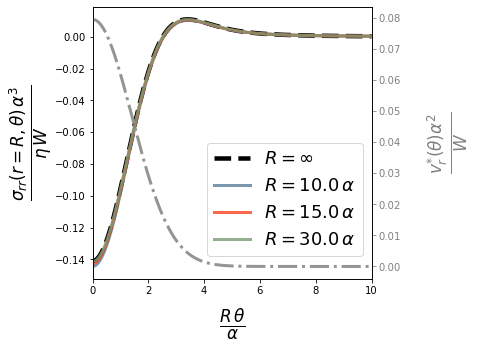

In [11]:
plt.figure ()

fig, ax1 = plt.subplots (figsize = (5, 5))

ax1.plot (r_alpha, sig_z_0_inf, linewidth = 1.5 * line_width, color = 'black', linestyle='--', label = r"$R = \infty$")

for i in range (len (R)):
    ax1.plot (R[i] / alpha * th, sig_r_list[i], linewidth = line_width, color=color_list[i], label = r"$R = " + str(R[i]/alpha) + r"\,\alpha$", alpha=0.8)

ax1.legend (fontsize = legend_font_size, bbox_to_anchor = (1.0, 0.05), loc=4)

ax1.set_xlabel(r'$\frac{R \, \theta}{\alpha}$',fontsize = label_font_size, labelpad = 10)
ax1.set_ylabel(r'$\frac{\sigma_{rr}\left(r=R, \theta \right) \, \alpha^3}{\eta \, W}$',fontsize = label_font_size,
               labelpad = 0, color = 'black')
ax1.tick_params('y', colors='black')

ax1.set_xlim (0.0, 10.0)

ax2 = ax1.twinx ()

ax2.plot (R[0] / alpha * th, v0_r[0], color=color_gray, linewidth = line_width, linestyle='-.')
    
ax2.set_ylabel(r'$\frac{v^{*}_{r}\left(\theta\right) \alpha ^ 2}{W}$',fontsize = label_font_size, labelpad = 25, color = 'gray')
ax2.tick_params('y', colors='gray')
ax2.set_xlim (0.0, 10.0)

(0.0, 10.0)

<Figure size 432x288 with 0 Axes>

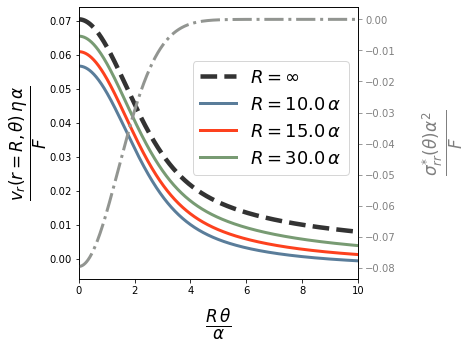

In [12]:
plt.figure ()

fig, ax1 = plt.subplots (figsize = (5, 5))

ax1.plot (r_alpha, v_z_0_inf, linewidth = line_width * 1.5, color = 'black', linestyle='--', label = r"$R = \infty$", alpha = 0.8)

for i in range (len (R)):
    ax1.plot (R[i] / alpha * th, v_r_list[i], linewidth = line_width, color=color_list[i], label = r"$R = " + str(R[i]/alpha) + r"\,\alpha$")

ax1.legend (fontsize = legend_font_size, bbox_to_anchor = (1.0, 0.35), loc=4)

ax1.set_xlabel(r'$\frac{R \, \theta}{\alpha}$',fontsize = label_font_size, labelpad = 10)
ax1.set_ylabel(r'$\frac{v_r\left(r=R, \theta \right) \,\eta\, \alpha}{F}$',fontsize = label_font_size, labelpad = 0, color = 'black')
ax1.tick_params('y', colors='black')

ax1.set_xlim (0.0, 10.0)

ax2 = ax1.twinx ()

ax2.plot (R[0] / alpha * th, sig0_r[0], color=color_gray, linewidth = line_width, linestyle='-.')
    
ax2.set_ylabel(r'$\frac{\sigma^{*}_{rr}\left(\theta \right) \alpha^2}{F}$',fontsize = label_font_size, labelpad = 25, color = 'gray')
ax2.tick_params('y', colors='gray')
ax2.set_xlim (0.0, 10.0)